In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as p9

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [77]:
df['BsmtQual'].value_counts(dropna=False)

TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64

In [56]:
sum(df['Alley'].isna()) / len(df)

0.9376712328767123

In [59]:
df.groupby('Alley', dropna=False).agg({'SalePrice': np.median})

,SalePrice
Alley,
Grvl,119500.0
Pave,172500.0
NaN,165000.0


# 1. Missing Values

* We first go through the columns with missing values and try to understand the reason of missing
* Then we pre-process the missing values by removing columns or rows or 

## 1.1 Get the percentage of NA values for each column

Only show the columns that have NA values

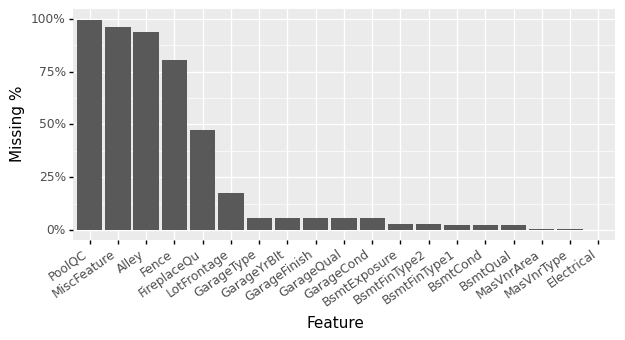

<ggplot: (8790368124654)>

In [175]:
na_freq = df.apply(lambda x: sum(x.isna()) / len(x), axis=0)
na_freq = (
    na_freq[na_freq>0]
    .reset_index()
    .rename(columns={'index': 'Feature', 0: 'Missing %'})
    .sort_values(by='Missing %', ascending=False)
)
na_freq['Feature'] = pd.Categorical(na_freq['Feature'], categories=na_freq['Feature'].tolist())
(
    p9.ggplot(na_freq, p9.aes('Feature', 'Missing %'))
    + p9.geom_bar(stat='identity')
    + p9.scale_y_continuous(labels=lambda x: ["{:.0%}".format(v) for v in x])
    + p9.theme(
        axis_text_x = p9.element_text(angle=35,hjust=1),
        figure_size = (7, 3)
    )
)

## 1.2 Find the reason for missing: missing at random, or missing for a reason

* Missing because the component does not exist in the house:
    * PoolQC
    * MiscFeature
    * Alley
    * Fence
    * FireplaceQu
    * GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
    * BsmtExposure (NA and "No" have different meaning)
    * BsmtFinType1, BsmtFinType2, BsmtCond, BsmtQual
    
    
* Missing at random
    * LotFrontage
    * MasVnrType & MasVnrArea
    * Electrical


### 1.2.1 Example of missing due to non-existance of a house component

In [105]:
# When there is no pool (PoolArea == 0), PoolQC is missing
(
    df.groupby('PoolQC', dropna=False)
    .agg({
        'PoolArea': [q05, np.median, q95]
    })
)

PoolArea               
            q05 median     q95
PoolQC                        
Ex       514.15  533.5  552.85
Fa       525.45  583.5  641.55
Gd       489.60  576.0  721.80
NaN        0.00    0.0    0.00

### 1.2.2 Confirm missing at random

In [106]:
# Define two helper functions for calculating percentiles
def q05(x):
    return np.quantile(x, 0.05)
def q95(x):
    return np.quantile(x, 0.95)

In [166]:
# LotFrontage:
# Missing vs non-missing: similar sale price and year built
#    (although there are some difference in median sale price)
# So we consider this as missing at random
# We can fill in the missing values by the median of lot frontage ( or use more advanced method )

(
    df.groupby(df['LotFrontage'].isna())
    .agg({
        'LotFrontage': [len, q05, np.median, q95],
        'SalePrice': [q05, np.median, q95],
        'YearBuilt': [q05, np.median, q95]
    })
)

LotFrontage                     SalePrice                      \
                    len   q05 median    q95       q05    median       q95   
LotFrontage                                                                 
False              1201  34.0   69.0  107.0   87000.0  159500.0  337500.0   
True                259   NaN    NaN    NaN  107900.0  172400.0  278000.0   

            YearBuilt                  
                  q05  median     q95  
LotFrontage                            
False          1915.0  1972.0  2007.0  
True           1930.9  1976.0  2003.0

In [103]:
# MasVnrType and MasVnrArea

# When MasVnrType is missing, the corresponding MasVnrArea value is also missing
# No systematic difference in the values in year_built and neighborhood
#    between MasVnrType missing and non-missing groups

# Fill in "None" and "0" for Type and Area, because that is the most observed values

(
    df.groupby('MasVnrType', dropna=False)
    .agg({
        'MasVnrArea': [len, q05, np.median, q95],
        'SalePrice': np.median,
        'YearBuilt': [q05, np.median, q95],
        'Neighborhood': lambda x: x.unique()
    })
)

MasVnrArea                      SalePrice YearBuilt          \
                  len   q05 median     q95    median       q05  median   
MasVnrType                                                               
BrkCmn             15  58.5  192.0  530.00  139000.0   1946.10  1961.0   
BrkFace           445  40.0  202.0  652.60  181000.0   1955.00  1988.0   
None              864   0.0    0.0    0.00  143000.0   1910.00  1961.0   
Stone             128  50.0  206.5  614.45  246839.0   1957.70  2006.0   
NaN                 8   NaN    NaN     NaN  203287.0   1972.75  2004.5   

                                                         Neighborhood  
               q95                                           <lambda>  
MasVnrType                                                             
BrkCmn      1969.6         [NAmes, ClearCr, BrkSide, OldTown, Sawyer]  
BrkFace     2006.0  [CollgCr, NoRidge, NAmes, NridgHt, Somerst, St...  
None        2006.0  [Veenker, Crawfor, Mitchel, OldTown, BrkSide, ...  
Stone       2009.0  [Somerst, NWAmes, NridgHt, CollgCr, Edwards, N...  
NaN         2007.0  [Gilbert, Crawfor, Somerst, SawyerW, NridgHt, ...

In [84]:
# Electrical

# There is only one missing data for the column "Electrical"
# And the "Utilities" column says it has all utilities.

# Since only one row, it's safe to remove this data

df[df['Electrical'].isna()]['Utilities']

1379    AllPub
Name: Utilities, dtype: object

## 1.3 Pre-process the missing values

# 2. Outliers

# 3. Categorical variable encoding

In [ ]:
# Categorical vs Numerical

# Looks like numerical, but should be categorical
# MSSubClass, OverallQual, OverallCond

# YrSold: Categorical
# Numerical : MoSold

# One-hot encoding - combine two columns by using OR operator first
# Condition1, Condition2
# Exterior1st, Exterior2nd

# One-hot encoding for BsmtFinType - do not remove first level
# Fill in actual SF into the corresponding column
# BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2

# All other columns of the "object" type ---> categorical

# All remaining columns: numerical

In [54]:
pd.DataFrame({'col': df.columns, 'type': list(df.dtypes)}).head(5)

,col,type
0,Id,int64
1,MSSubClass,int64
2,MSZoning,object
3,LotFrontage,float64
4,LotArea,int64


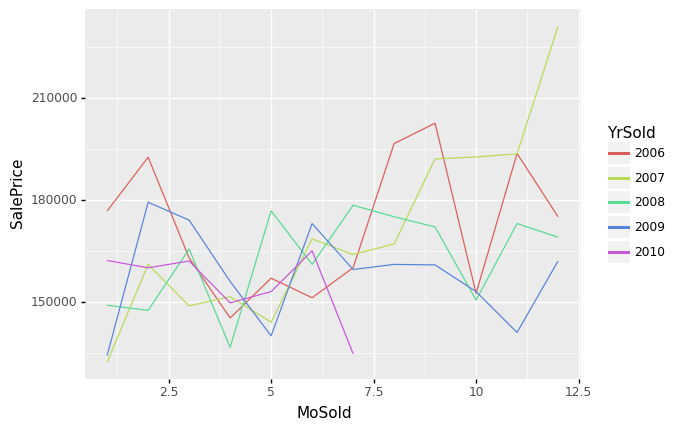

<ggplot: (8790369097430)>

In [34]:
# MoSold vs SalePrice: nonlinear relation, some quadratic transformation may be useful here.
df_plot = df.groupby(['YrSold', 'MoSold']).agg({'SalePrice': np.median}).reset_index()
df_plot['YrSold'] = df_plot['YrSold'].astype(str)
p9.ggplot(df_plot, p9.aes(x='MoSold', y='SalePrice', group='YrSold', color='YrSold')) + p9.geom_line()

/home/ye/.local/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 229 rows containing non-finite values.


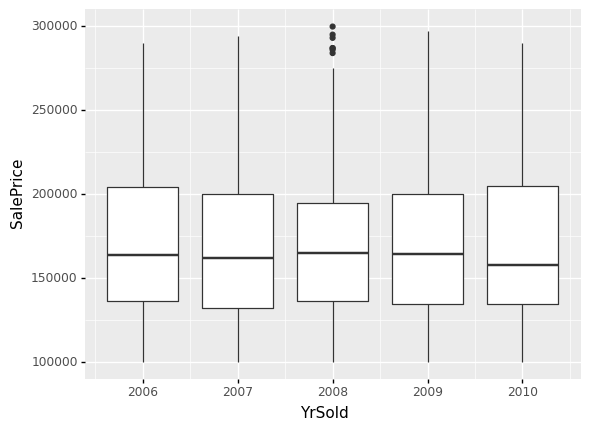

<ggplot: (8790368875783)>

In [41]:
# Some years have lower price. But the relation is not simple.
# Consider it as categorical and let the algorithm decide the impact of this feature to the price.
p9.ggplot(df, p9.aes(x='YrSold', y='SalePrice', group='YrSold')) + p9.geom_boxplot() + p9.ylim(100000, 300000)

/home/ye/.local/lib/python3.9/site-packages/plotnine/stats/stat_smooth.py:201: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


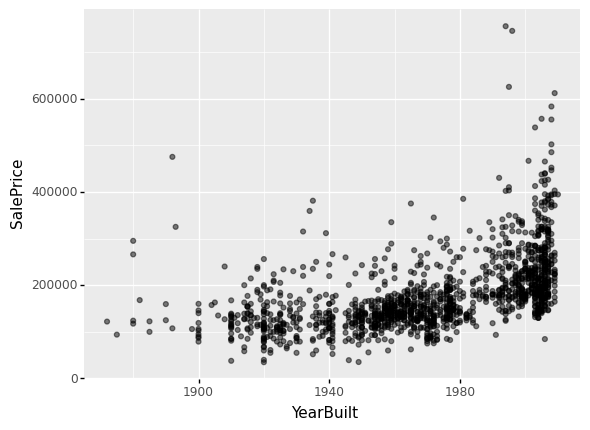

<ggplot: (8790368236264)>

In [49]:
# YearBuilt: nonlinear relation
(
    p9.ggplot(df, p9.aes(x='YearBuilt', y='SalePrice', group='YearBuilt'))
    + p9.geom_point(alpha=0.5)
    + p9.geom_smooth(method='lm')
)